In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import scipy
import skimage
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
import nuclei
from skimage.transform import resize
from IPython.core.debugger import set_trace

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

NUCLEI_DIR = "../../input"

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #2
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/matplotlib/__init__.py:962: UserWarning: Duplicate key in file "/home/ubuntu/.config/matplotlib/matplotlibrc", line #3
  (fname, cnt))
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
config = nuclei.NucleiConfig()
config.display()
print(MODEL_DIR)


Configurations:
BACKBONE_SHAPES                [[256 256]
 [128 128]
 [ 64  64]
 [ 32  32]
 [ 16  16]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     2
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 2
IMAGE_MAX_DIM                  1024
IMAGE_MIN_DIM                  800
IMAGE_PADDING                  True
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               100
MEAN_PIXEL                     [44.57284587, 40.71265898, 48.6901747]
MINI_MASK_SHAPE                (56, 56)
NAME                           nuclei
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
POST_NM

## Notebook Preferences

In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
dataset = nuclei.NucleiDataset()
dataset.load_nuclei(NUCLEI_DIR, "train")
dataset.prepare()

dataset_test = nuclei.NucleiDataset()
dataset_test.load_nuclei(NUCLEI_DIR, "test")
dataset_test.prepare()

In [5]:
dataset_train, dataset_val = dataset.extract_train_val()
dataset_train.prepare()
dataset_val.prepare()

In [6]:
len(dataset_val.image_ids)

34

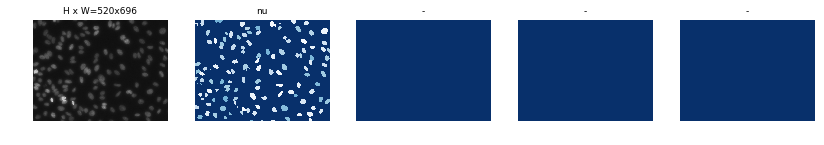

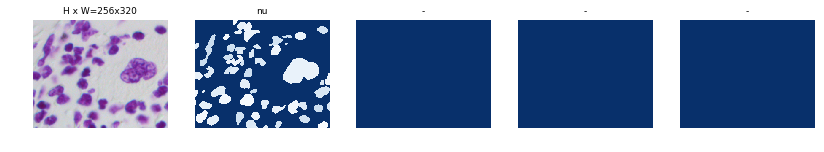

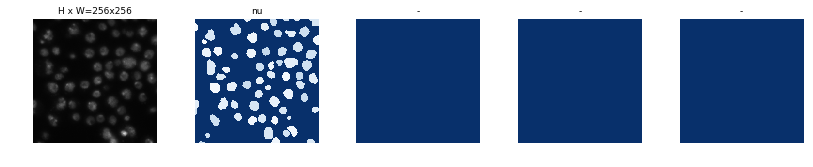

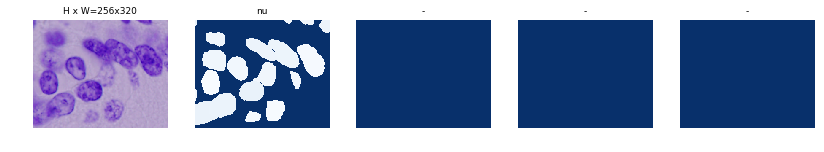

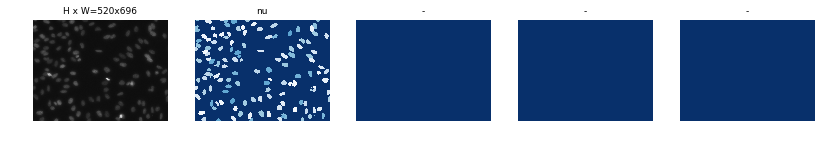

In [7]:
# Load and display random samples
image_ids = np.random.choice(dataset_val.image_ids, 4)
image_ids = np.append(image_ids, [31])
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

## Ceate Model

In [47]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

In [14]:
print(MODEL_DIR)

/home/ubuntu/nuclei/solutions/kmrcnn/logs


In [ ]:
# Which weights to start with?
init_with = "last"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last()[1], by_name=True)

print(model.log_dir)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [16]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset_val, dataset_val, 
            learning_rate=config.LEARNING_RATE, 
            epochs=10000, 
            layers='heads')


Starting at epoch 222. LR=0.001

Checkpoint Path: /home/ubuntu/nuclei/solutions/kmrcnn/logs/nuclei20180217T2339/mask_rcnn_nuclei_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistri

/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:96: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/keras/engine/training.py:2033: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


Epoch 223/10000
17/17 [==============================] - 119s 7s/step - loss: 0.2044 - rpn_class_loss: 9.7091e-04 - rpn_bbox_loss: 0.0097 - mrcnn_class_loss: 0.0739 - mrcnn_bbox_loss: 0.0164 - mrcnn_mask_loss: 0.1034 - val_loss: 0.3734 - val_rpn_class_loss: 0.0015 - val_rpn_bbox_loss: 0.0098 - val_mrcnn_class_loss: 0.2514 - val_mrcnn_bbox_loss: 0.0154 - val_mrcnn_mask_loss: 0.0953
Epoch 224/10000
17/17 [==============================] - 62s 4s/step - loss: 0.2034 - rpn_class_loss: 9.8226e-04 - rpn_bbox_loss: 0.0085 - mrcnn_class_loss: 0.0763 - mrcnn_bbox_loss: 0.0152 - mrcnn_mask_loss: 0.1025 - val_loss: 0.3726 - val_rpn_class_loss: 0.0012 - val_rpn_bbox_loss: 0.0091 - val_mrcnn_class_loss: 0.2467 - val_mrcnn_bbox_loss: 0.0162 - val_mrcnn_mask_loss: 0.0993
Epoch 225/10000
17/17 [==============================] - 62s 4s/step - loss: 0.1996 - rpn_class_loss: 0.0020 - rpn_bbox_loss: 0.0066 - mrcnn_class_loss: 0.0757 - mrcnn_bbox_loss: 0.0134 - mrcnn_mask_loss: 0.1019 - val_loss: 0.3695 - 

17/17 [==============================] - 62s 4s/step - loss: 0.1647 - rpn_class_loss: 6.3109e-04 - rpn_bbox_loss: 0.0033 - mrcnn_class_loss: 0.0607 - mrcnn_bbox_loss: 0.0099 - mrcnn_mask_loss: 0.0901 - val_loss: 0.3436 - val_rpn_class_loss: 7.3361e-04 - val_rpn_bbox_loss: 0.0053 - val_mrcnn_class_loss: 0.2395 - val_mrcnn_bbox_loss: 0.0103 - val_mrcnn_mask_loss: 0.0878
Epoch 266/10000
17/17 [==============================] - 62s 4s/step - loss: 0.1649 - rpn_class_loss: 0.0010 - rpn_bbox_loss: 0.0032 - mrcnn_class_loss: 0.0638 - mrcnn_bbox_loss: 0.0087 - mrcnn_mask_loss: 0.0881 - val_loss: 0.3463 - val_rpn_class_loss: 7.1035e-04 - val_rpn_bbox_loss: 0.0051 - val_mrcnn_class_loss: 0.2434 - val_mrcnn_bbox_loss: 0.0103 - val_mrcnn_mask_loss: 0.0867
Epoch 267/10000
17/17 [==============================] - 61s 4s/step - loss: 0.1562 - rpn_class_loss: 0.0013 - rpn_bbox_loss: 0.0031 - mrcnn_class_loss: 0.0551 - mrcnn_bbox_loss: 0.0085 - mrcnn_mask_loss: 0.0882 - val_loss: 0.3443 - val_rpn_class

Process Process-2:
Process Process-3:
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/keras/utils/data_utils.py", line 657, in _data_generator_task
    time.sleep(self.wait_time)
KeyboardInterrupt
  File "/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/ubuntu/anaconda3/envs/tf_pycoco/lib/python3.6/site-packages/keras/utils/data_utils.py", line 654, in _data_generator_task
    generator

KeyboardInterrupt: 

## Detection

In [9]:
class InferenceConfig(nuclei.NucleiConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    POST_NMS_ROIS_INFERENCE = 2000

inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=MODEL_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path = model.find_last()[1]

# Load trained weights (fill in path to trained weights here)
assert model_path != "", "Provide path to trained weights"
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  /home/ubuntu/nuclei/solutions/kmrcnn/logs/nuclei20180217T2339/mask_rcnn_nuclei_0281.h5


8
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9
Thresh	TP	FP	FN	Prec.
0.500	183	0	0	1.000
0.550	183	0	0	1.000
0.600	183	0	0	1.000
0.650	183	0	0	1.000
0.700	183	0	0	1.000
0.750	183	0	0	1.000
0.800	183	0	0	1.000
0.850	183	0	0	1.000
0.900	183	0	0	1.000
0.950	183	0	0	1.000
AP	-	-	-	1.000
original_image           shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
image_meta               shape: (10,)                 min:    0.00000  max: 1024.00000
gt_class_id              shape: (183,)                min:    1.00000  max:    1.00000
gt_bbox                  shape: (183, 4)              min:    0.00000  max: 1023.00000
gt_mask                  shape: (1024, 1024, 183)     min:    0.00000  max:  255.00000


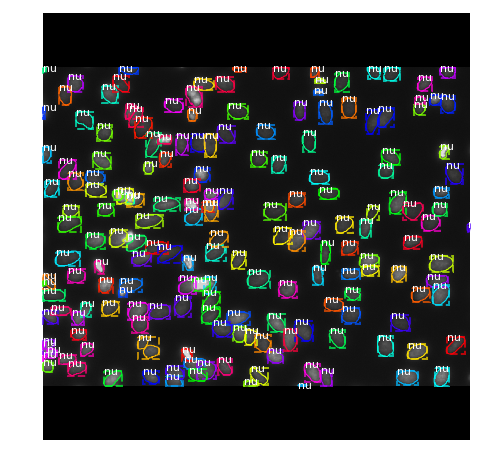

In [10]:
# Test on a random image
# image_id = random.choice(dataset_val.image_ids)
image_id = 8
print(image_id)
print(dataset_val.image_info[image_id]['id'])
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)

pred_mask, ground_mask = utils.resh_to_orig(gt_mask, image_meta, dataset=dataset_val)

# # Test the IoU, Ralph!
utils.iou_metric(ground_mask,pred_mask,print_table=True)


log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset_train.class_names, figsize=(8, 8))

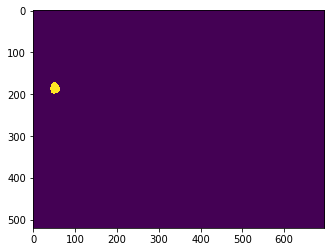

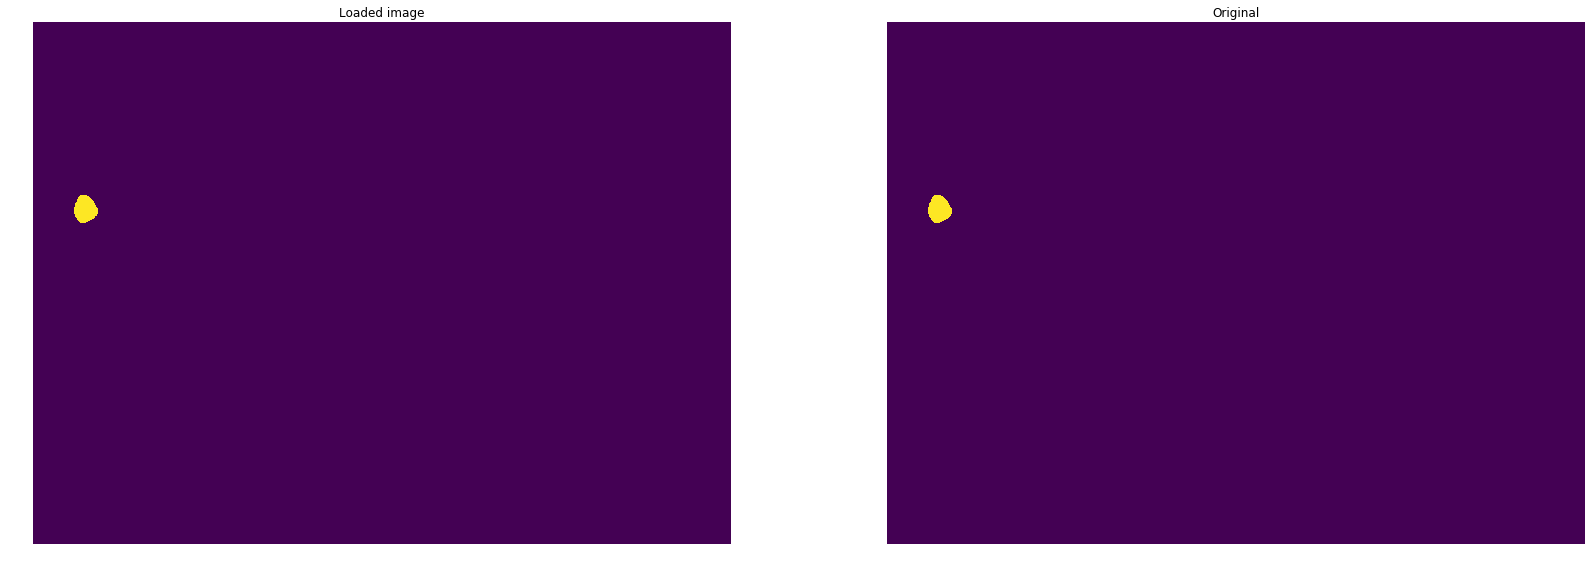

In [11]:
plt.imshow(pred_mask[:,:,0])
# Show label image
fig, axes = plt.subplots(1,2, figsize=(24,8))
axes[0].imshow(pred_mask[:,:,0])
axes[0].set_title("Loaded image")
axes[1].imshow(ground_mask[:,:,0])
axes[1].set_title("Original")
plt.tight_layout()
for ax in axes:
    ax.axis('off')

In [12]:
(pred_mask == ground_mask).any()

True

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  233.00000
molded_images            shape: (1, 1024, 1024, 3)    min:  -48.69017  max:  192.28734
image_metas              shape: (1, 10)               min:    0.00000  max: 1024.00000
(1024, 1024, 7)


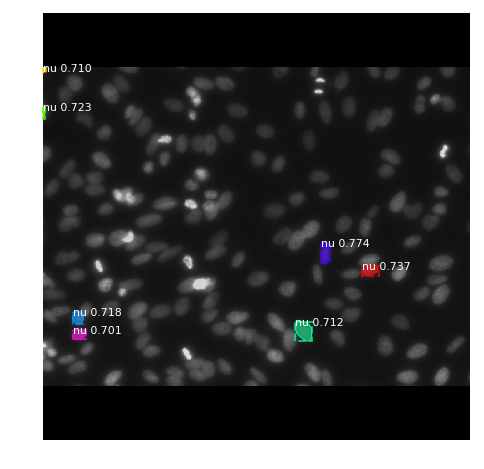

In [13]:
results = model.detect([original_image], verbose=1)

r = results[0]
print(r['masks'].shape)
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [14]:
r.keys()

dict_keys(['rois', 'class_ids', 'scores', 'masks'])

In [15]:
# Compute competition mAP @ different iou thresholds
# iou_metric(ground_mask,)
r['masks'].shape
pred_mask, ground_mask = utils.resh_to_orig(r['masks'], image_meta, dataset=dataset_val)
log('pred_mask',pred_mask)
log('ground_mask',ground_mask)
utils.iou_metric(ground_mask,pred_mask,print_table=True)

pred_mask                shape: (520, 696, 7)         min:    0.00000  max:    1.00000
ground_mask              shape: (520, 696, 183)       min:    0.00000  max:    1.00000
Thresh	TP	FP	FN	Prec.
0.500	7	0	176	0.038
0.550	7	0	176	0.038
0.600	7	0	176	0.038
0.650	7	0	176	0.038
0.700	7	0	176	0.038
0.750	7	0	176	0.038
0.800	7	0	176	0.038
0.850	6	1	177	0.033
0.900	1	6	182	0.005
0.950	0	7	183	0.000
AP	-	-	-	0.031


0.030565926378470925

In [ ]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 10 images. Increase for better accuracy.
# image_ids = np.random.choice(dataset_val.image_ids, 34)
image_ids = dataset_val.image_ids
APs = []
print(image_ids.shape)
program_starts = time.time()
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    # molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    # Compute AP
    # AP, precisions, recalls, overlaps =\
        # utils.compute_ap(gt_bbox, gt_class_id,
                         # r["rois"], r["class_ids"], r["scores"])
    pred_mask, ground_mask = utils.resh_to_orig(r['masks'], image_meta, dataset=dataset_val)
    AP = utils.iou_metric(ground_mask,pred_mask)
    if AP < 0.5:
        print(image_id)
        print(dataset_val.image_info[image_id]['id'])
        print(AP)
    # print(AP)
    APs.append(AP)
print("It has been {0} minutes since the loop started".format((time.time() - program_starts)/60))
print("mAP: ", np.mean(APs))


(34,)
8
4dbbb275960ab9e4ec2c66c8d3000f7c70c8dce5112df591b95db84e25efa6e9
0.030565926378470925
21
12aeefb1b522b283819b12e4cfaf6b13c1264c0aadac3412b4edd2ace304cb40
0.4004892586039176
30
3f9fc8e63f87e8a56d3eaef7db26f1b6db874d19f12abd5a752821b78d47661e
0.054291146617095984


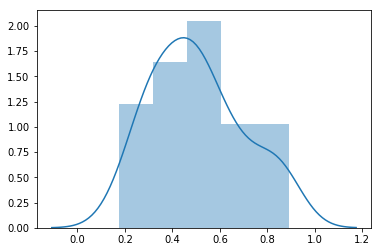

In [20]:
import seaborn as sns
sns.distplot(APs)